In [1]:
# python librairies installation
!pip install -q split-folders -q matplotlib -q opencv-python -q spicy

!pip install -q image_tabular

!pip install -q fastai


In [2]:
!pip install opencv-python


In [3]:
pip install keras


Note: you may need to restart the kernel to use updated packages.


In [4]:
# display, transform, read, split ...
import numpy as np
import cv2 as cv
import os
import splitfolders
import seaborn as sns
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import random

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.preprocessing import LabelEncoder

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


#from fastai.tabular import ImageTabular

### Step 2 - Data preprocessing

To use your data (images), you have to pre-process them.

#### 1. Visualize dataset images

The first step is to display an image of each class to see what it looks like.

Here, there is **5 classes** (for 5 flower types).

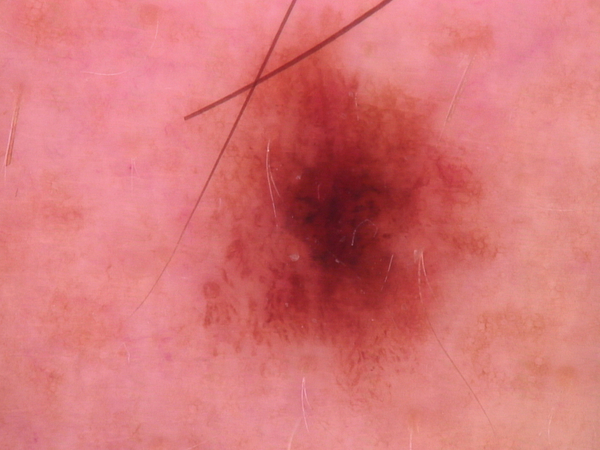

In [5]:
# Melanocytic nevi
img_Melanocyticnevi = image.load_img("C:\\Users\\User\\Downloads\\data\\Melanocytic_nevi\\ISIC_0024306.jpg")
img_Melanocyticnevi

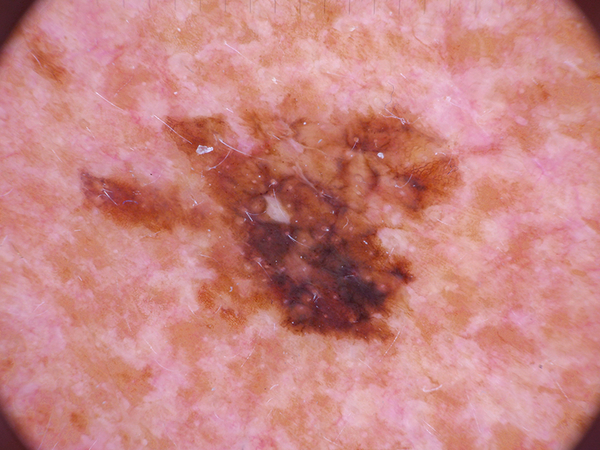

In [5]:
# Melanoma
img_Melanoma = image.load_img("C:\\Users\\User\\Downloads\\data\\Melanoma\\ISIC_0024310.jpg")
img_Melanoma

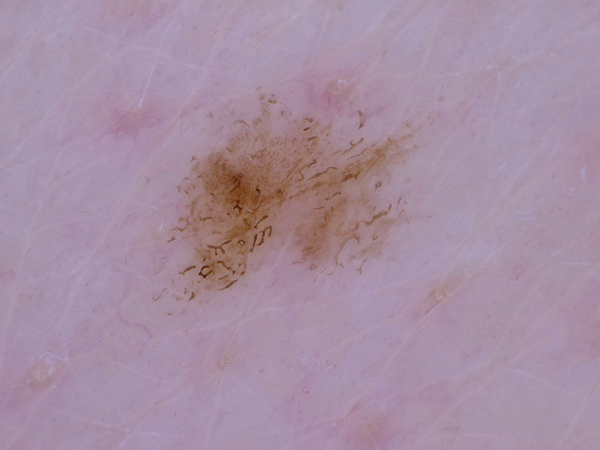

In [6]:
# Benign keratosis-like lesions
img_bk = image.load_img("C:\\Users\\User\\Downloads\\data\\Benign_keratosis_like_lesions\\ISIC_0024324.jpg")
img_bk


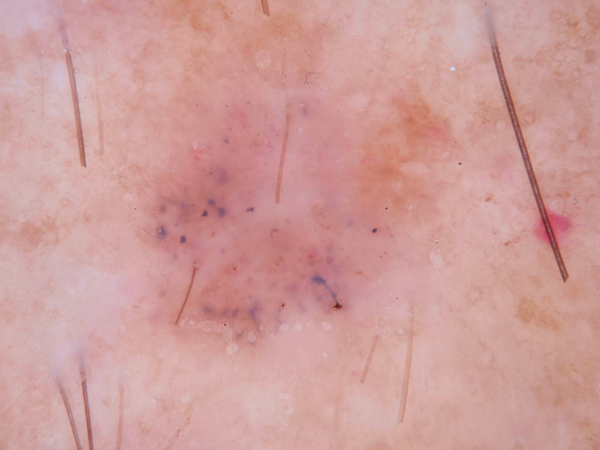

In [7]:
# Basal cell carcinoma
img_bc = image.load_img("C:\\Users\\User\\Downloads\\data\\Basal_cell_carcinoma\\ISIC_0024331.jpg")
img_bc

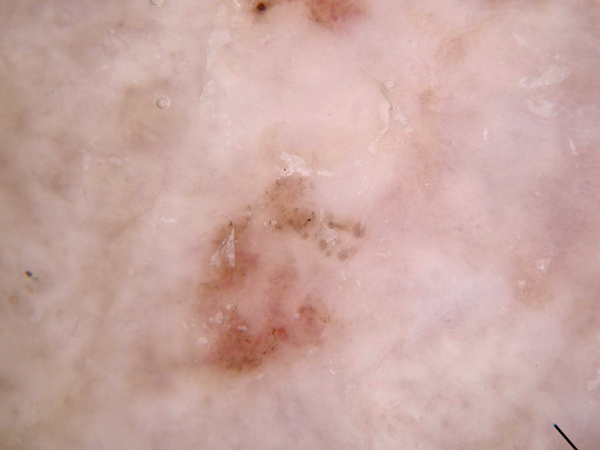

In [8]:
# Actinic keratoses
img_ak = image.load_img("C:\\Users\\User\\Downloads\\data\\Actinic_keratoses\\ISIC_0024329.jpg")
img_ak

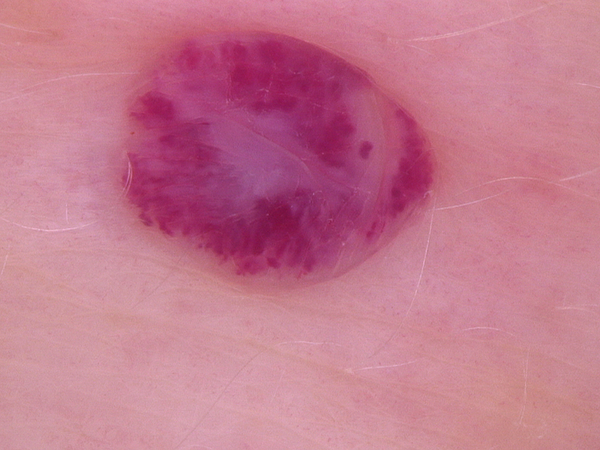

In [9]:
#Vascular lesions
img_vl = image.load_img("C:\\Users\\User\\Downloads\\data\\Vascular_lesions\\ISIC_0024370.jpg")
img_vl

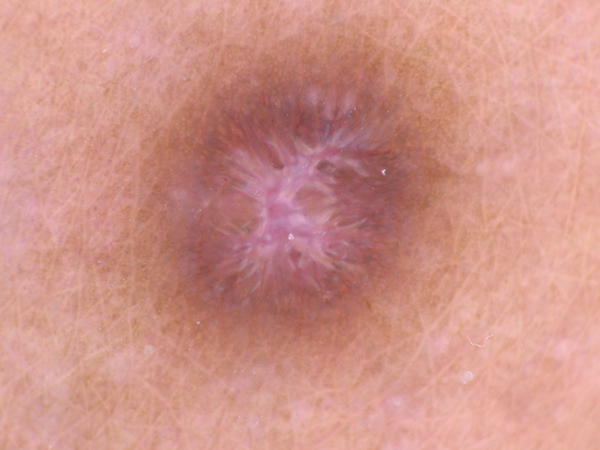

In [10]:
#Dermatofibroma
img_df = image.load_img("C:\\Users\\User\\Downloads\\data\\Dermatofibroma\\ISIC_0024318.jpg")
img_df

#### 2. Split data to use a ResNet model

By using a **ResNet** model, your dataset has to be split as follow:

<img src="attachment:016f5918-d35a-4496-83a9-42843bbcd4fd.png"  width=400>

If this is not the case for your image classification dataset, follow the steps below.

1. Have a separate dataset as follows: **one folder per class**.

<img src="attachment:6cb999f7-3dfb-41df-a302-5115b27cb719.png" width=800>

2. Then play the following cell to split the dataset into training, validation and test sets.

In [6]:
# split data in a new folder named data-split
splitfolders.ratio("C:\\Users\\User\\Downloads\\data", output="C:\\Users\\User\\Downloads\\data-split", seed=1337, ratio=(0.7, 0.2, 0.1), group_prefix=None, move=False)

Copying files: 9798 files [01:33, 104.77 files/s]


Your data should, now, be split as follows:

<img src="attachment:713d2de3-0894-411b-8e55-0820b5768e93.png" width=900>

In [29]:
metadados = pd.read_excel('C:\\Users\\User\\Downloads\\HAM10000_metadata.xlsx')

In [30]:

def is_numeric(col):
    return pd.to_numeric(col, errors='coerce').notna().all()

for column in metadados.columns:
    if is_numeric(metadados[column]):
        metadados[column].fillna(metadados[column].mean(), inplace=True)
    else:
        metadados[column].fillna(metadados[column].mode()[0], inplace=True)


print(f"Amount of nulls left in the dataframe after treatment: {sum(pd.isnull(metadados.columns))}")

Amount of nulls left in the dataframe after treatment: 0


In [9]:
metadados.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [31]:
df = metadados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           10015 non-null  float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [11]:
def exibir_imagem(image_id):
    # Encontre a linha correspondente ao image_id na planilha
    linha = metadados[metadados['image_id'] == image_id].iloc[0]

    # Construa o caminho completo para a imagem
    caminho_imagem = os.path.join('C:\\Users\\User\\Downloads\\data', f'{image_id}.jpg')

    # Carregue e exiba a imagem
    imagem = Image.open(caminho_imagem)
    plt.imshow(imagem)
    plt.title(f"Lesion ID: {image_id}\nDiagnóstico: {linha['dx']}\nIdade: {linha['age']}\nSexo: {linha['sex']}\nLocalização: {linha['localization']}")
    plt.axis('off')
    plt.show()


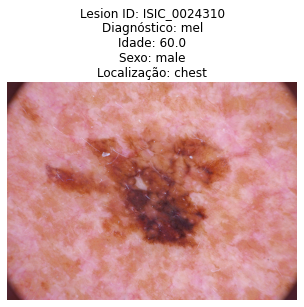

In [39]:
def exibir_imagem(image_id):
    # Construa o caminho completo para o diretório de imagens
    diretorio_imagens = "C:\\Users\\User\\Downloads\\data"
    linha = metadados[metadados['image_id'] == image_id].iloc[0]

    # Itere sobre todas as pastas dentro do diretório de imagens
    for pasta in os.listdir(diretorio_imagens):
        pasta_completa = os.path.join(diretorio_imagens, pasta)

        # Verifique se a entrada é um diretório
        if os.path.isdir(pasta_completa):
            # Construa o caminho completo para a imagem na subpasta atual
            caminho_imagem = os.path.join(pasta_completa, f'{image_id}.jpg')

            # Verifique se a imagem existe na subpasta atual
            if os.path.exists(caminho_imagem):
                # Carregue e exiba a imagem
                imagem = Image.open(caminho_imagem)
                plt.imshow(imagem)
                plt.title(f"Lesion ID: {image_id}\nDiagnóstico: {linha['dx']}\nIdade: {linha['age']}\nSexo: {linha['sex']}\nLocalização: {linha['localization']}")
                #plt.title(f"Lesion ID: {image_id}\nSubpasta: {pasta}")
                plt.axis('off')
                plt.show()
                return

# Chame a função para exibir uma imagem de cada subpasta
exibir_imagem("ISIC_0024310")  # Substitua pelo image_id desejado


In [32]:
# Contagem de valores únicos para diagnóstico (dx)
contagem_dx = metadados['dx'].value_counts()
print(contagem_dx)

# Contagem de valores únicos para sexo (sex)
contagem_sex = metadados['sex'].value_counts()
print(contagem_sex)

# Contagem de valores únicos para localização (localization)
contagem_localization = metadados['localization'].value_counts()
print(contagem_localization)


nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64
male       5406
female     4552
unknown      57
Name: sex, dtype: int64
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64


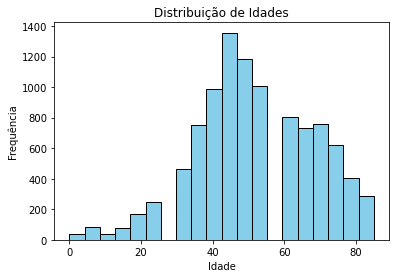

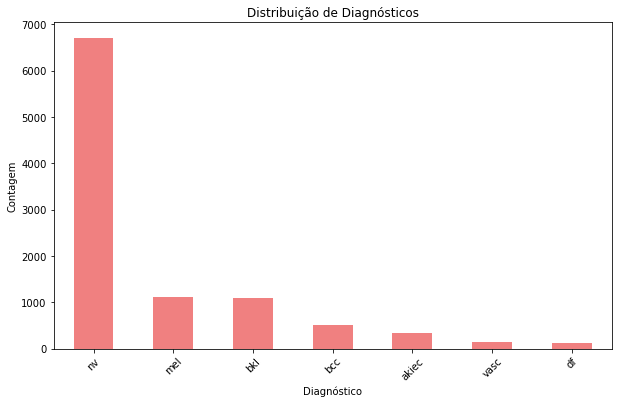

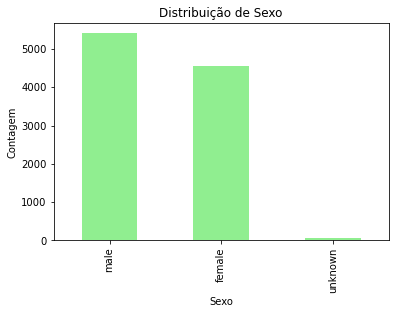

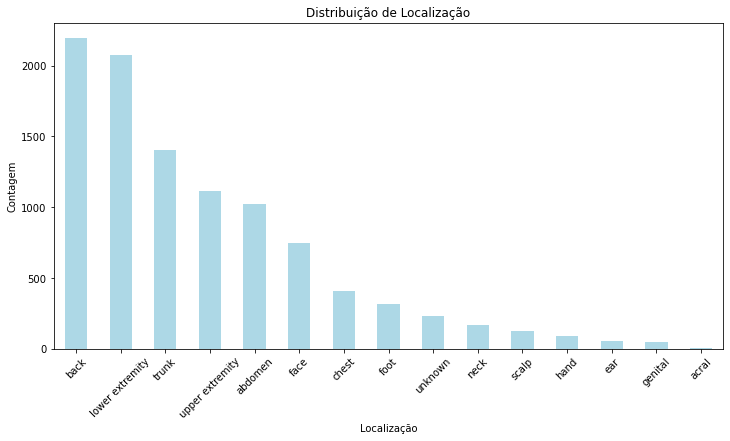

In [13]:
# Histograma da idade
plt.hist(metadados['age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.title('Distribuição de Idades')
plt.show()

# Gráfico de barras para diagnóstico (dx)
plt.figure(figsize=(10, 6))
metadados['dx'].value_counts().plot(kind='bar', color='lightcoral')
plt.xlabel('Diagnóstico')
plt.ylabel('Contagem')
plt.title('Distribuição de Diagnósticos')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para sexo (sex)
plt.figure(figsize=(6, 4))
metadados['sex'].value_counts().plot(kind='bar', color='lightgreen')
plt.xlabel('Sexo')
plt.ylabel('Contagem')
plt.title('Distribuição de Sexo')
plt.show()

# Gráfico de barras para localização (localization)
plt.figure(figsize=(12, 6))
metadados['localization'].value_counts().plot(kind='bar', color='lightblue')
plt.xlabel('Localização')
plt.ylabel('Contagem')
plt.title('Distribuição de Localização')
plt.xticks(rotation=45)
plt.show()


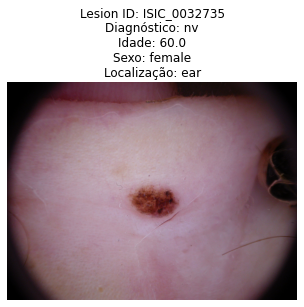

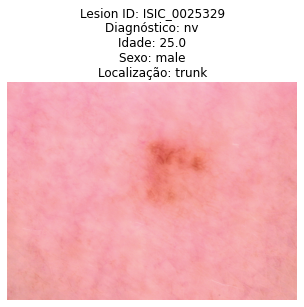

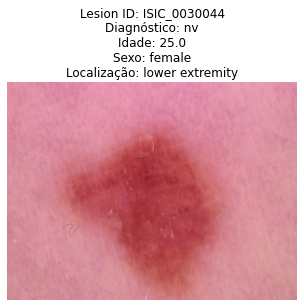

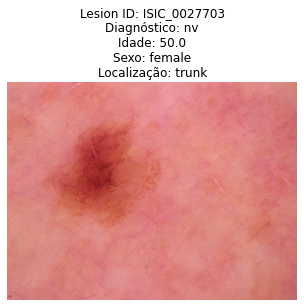

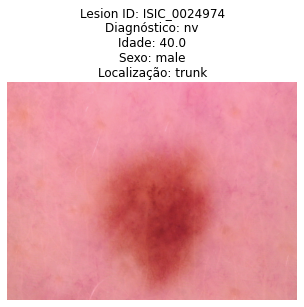

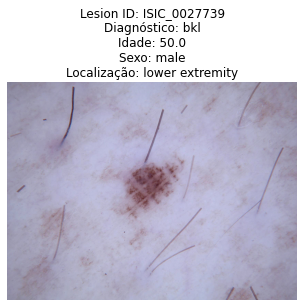

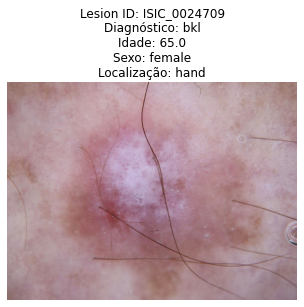

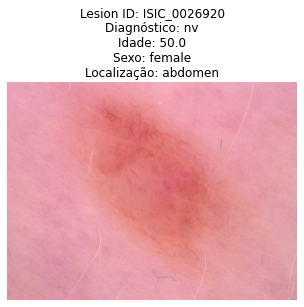

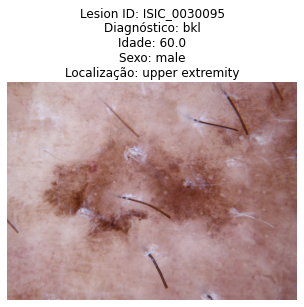

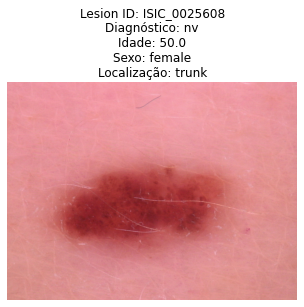

In [41]:
# Diretório onde suas imagens estão armazenadas
pasta_imagens = 'C:\\Users\\User\\Downloads\\data'

# Função para listar recursivamente todos os arquivos de imagem em um diretório
def listar_imagens_em_subpastas(pasta):
    imagens = []
    for pasta_raiz, subpastas, arquivos in os.walk(pasta):
        for arquivo in arquivos:
            if arquivo.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                caminho_completo = os.path.join(pasta_raiz, arquivo)
                imagens.append(caminho_completo)
    return imagens

# Lista de todos os arquivos de imagem nas subpastas
arquivos_imagens = listar_imagens_em_subpastas(pasta_imagens)

# Selecionar aleatoriamente 10 imagens
imagens_aleatorias = random.sample(arquivos_imagens, 10)

# Loop para exibir as 10 imagens aleatórias
for imagem in imagens_aleatorias:
    lesion_id = os.path.splitext(os.path.basename(imagem))[0]  # Obtém o lesion_id a partir do nome do arquivo
    exibir_imagem(lesion_id)  # Substitua 'exibir_imagem' pela função que você usa para exibir imagens


Tratamento do Metadados e imagem fazendo o Merge

In [33]:
metadados.drop(columns=['dx_type','lesion_id'],inplace = True)

In [34]:
metadados.columns

Index(['image_id', 'dx', 'age', 'sex', 'localization'], dtype='object')

In [35]:
label_encoder = LabelEncoder()

colunas = ['dx', 'age', 'sex', 'localization']

# List of columns you want to encode
columns_to_encode = metadados[colunas]

# Apply LabelEncoder to the selected columns
for column in columns_to_encode:
    metadados[column] = label_encoder.fit_transform(metadados[column])

# Display the modified DataFrame
print(metadados)

           image_id  dx  age  sex  localization
0      ISIC_0027419   2   16    1            11
1      ISIC_0025030   2   16    1            11
2      ISIC_0026769   2   16    1            11
3      ISIC_0025661   2   16    1            11
4      ISIC_0031633   2   15    1             4
...             ...  ..  ...  ...           ...
10010  ISIC_0033084   0    8    1             0
10011  ISIC_0033550   0    8    1             0
10012  ISIC_0033536   0    8    1             0
10013  ISIC_0032854   0   16    1             5
10014  ISIC_0032258   4   14    0             2

[10015 rows x 5 columns]


In [36]:
metadados.head()

image_id  dx  age  sex  localization
0  ISIC_0027419   2   16    1            11
1  ISIC_0025030   2   16    1            11
2  ISIC_0026769   2   16    1            11
3  ISIC_0025661   2   16    1            11
4  ISIC_0031633   2   15    1             4

In [37]:
independente = pd.DataFrame()
dependente = pd.DataFrame()
independente = metadados
dependente = metadados.pop('dx')
# Your data and labels
X, y = independente, dependente

# First, split the data into 80% for training and 20% for testing + validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Now you have the following splits:
# - X_train, y_train: 70% of the original data for training
# - X_test, y_test: 10% of the original data for testing
# - X_val, y_val: 20% of the original data for validation


In [38]:
independente.head()

image_id  age  sex  localization
0  ISIC_0027419   16    1            11
1  ISIC_0025030   16    1            11
2  ISIC_0026769   16    1            11
3  ISIC_0025661   16    1            11
4  ISIC_0031633   15    1             4

In [ ]:
import shutil

# Suponha que você tenha um mapeamento entre IDs e nomes de arquivos em um DataFrame chamado "mapeamento"
# O mapeamento pode ser criado assim:
# mapeamento = pd.DataFrame({'id': lista_de_ids, 'filename': lista_de_nomes_de_arquivos})

# Suponha que você tenha separado seus dados em X_train, y_train, X_test e y_test


# Diretórios de destino para as imagens de treinamento e teste
diretorio_treinamento = 'C:\\Users\\User\\Downloads\\dir_treino'
diretorio_teste = 'C:\\Users\\User\\Downloads\\dir_teste'

# Crie os diretórios se eles não existirem
os.makedirs(diretorio_treinamento, exist_ok=True)
os.makedirs(diretorio_teste, exist_ok=True)

# Separe as imagens de treinamento com base nos IDs
for id_imagem in X_train['image_id']:
    nome_arquivo = metadados[metadados['image_id'] == id_imagem]['image_id'].values[0]
    origem = os.path.join('C:\\Users\\User\\Downloads\\data-split\\train', nome_arquivo)
    destino = os.path.join(diretorio_treinamento, nome_arquivo)
    shutil.copy(origem, destino)

# Separe as imagens de teste com base nos IDs
for id_imagem in X_test['image_id']:
    nome_arquivo = metadados[metadados['image_id'] == id_imagem]['image_id'].values[0]
    origem = os.path.join('C:\\Users\\User\\Downloads\\data-split\\test', nome_arquivo)
    destino = os.path.join(diretorio_teste, nome_arquivo)
    shutil.copy(origem, destino)



In [39]:
import os
import shutil

# Diretórios de destino para as imagens de treinamento e teste
diretorio_treinamento = 'C:\\Users\\User\\Downloads\\dir_treino'
diretorio_teste = 'C:\\Users\\User\\Downloads\\dir_teste'

# Crie os diretórios se eles não existirem
os.makedirs(diretorio_treinamento, exist_ok=True)
os.makedirs(diretorio_teste, exist_ok=True)

# Função para copiar imagens de uma pasta de origem para uma pasta de destino
def copiar_imagens(origem, destino):
    for pasta_atual, subpastas, arquivos in os.walk(origem):
        for arquivo in arquivos:
            if arquivo.endswith('.jpg'):  # Verifica se o arquivo é uma imagem (ou outro formato desejado)
                caminho_origem = os.path.join(pasta_atual, arquivo)
                caminho_destino = os.path.join(destino, arquivo)
                shutil.copy(caminho_origem, caminho_destino)

# Itere por todas as subpastas e copie as imagens de treinamento com base nos IDs
for id_imagem in X_train['image_id']:
    origem = os.path.join('C:\\Users\\User\\Downloads\\data-split\\train', id_imagem)
    copiar_imagens(origem, diretorio_treinamento)

# Itere por todas as subpastas e copie as imagens de teste com base nos IDs
for id_imagem in X_test['image_id']:
    origem = os.path.join('C:\\Users\\User\\Downloads\\data-split\\test', id_imagem)
    copiar_imagens(origem, diretorio_teste)


In [40]:
X_train.shape,X_val.shape,X_test.shape

NameError: name 'X_val' is not defined

In [ ]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Now, X_train_scaled, X_val_scaled, and X_test_scaled contain the scaled data


In [ ]:
X_train_scaled.shape

In [ ]:
# Create a feedforward neural network model
y_train_onehot = to_categorical(y_train, num_classes=7)
y_test_onehot = to_categorical(y_test, num_classes=7)


model_ff = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer with the number of features
    layers.Dense(128, activation='relu'),
    layers.Dense(512, activation='relu'),  # Additional dense layer
    layers.Dense(256, activation='relu'),  # Additional dense layer
    layers.Dense(128, activation='relu'),  # Additional dense layer
    layers.Dense(64, activation='relu'),   # Additional dense layer
    layers.Dense(7, activation='softmax')  # Output layer with 7 units and softmax activation for multiclass
])

# Compile the model
model_ff.compile(optimizer='adam',
                 loss='categorical_crossentropy',  # Use categorical_crossentropy for multiclass
                 metrics=['accuracy'])

# Print model summary
model_ff.summary()

# Train the model
model_ff.fit(X_train_scaled, y_train_onehot, epochs=10, batch_size=32)

# Evaluate the model on the test data
test_loss, test_acc = model_ff.evaluate(X_test_scaled, y_test_onehot)
print(f'Test accuracy: {test_acc}')


In [16]:
y_train_onehot.shape

(8012, 7)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

# Input layer for tabular data
input_tabular = Input(shape=(X_train_scaled.shape[1],))

# Dense layers with dropout
x = layers.Dense(512, activation='relu')(input_tabular)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output layer for multiclass classification
output_tabular = Dense(7, activation='softmax')(x)

# Create the model
model_ff_transformed = Model(inputs=input_tabular, outputs=output_tabular)

# Compile the transformed model
model_ff_transformed.compile(optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

# Print model summary
model_ff_transformed.summary()

# Train the transformed model
model_ff_transformed.fit(X_train_scaled, y_train_onehot, epochs=10, batch_size=32)

# Evaluate the transformed model on the test data
test_loss, test_acc = model_ff_transformed.evaluate(X_test_scaled, y_test_onehot)
print(f'Test accuracy: {test_acc}')


In [21]:
# Assuming you have already trained your model and made predictions
# Replace y_pred with your model's predictions on the test data
y_pred = model.predict(X_test_scaled)

# Convert one-hot encoded predictions back to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Assuming y_test is the true class labels in integer format
# If you used one-hot encoding for y_test, you may need to convert it back as well
# Replace y_test with your true class labels
y_test_labels = y_test

# Generate a classification report
report = classification_report(y_test_labels, y_pred_labels)

# Print the classification report
print(report)

32/32 [==============================] - 0s 484us/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.00      0.00      0.00        38
           2       0.29      0.14      0.19       113
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00       113
           5       0.70      0.99      0.82       674
           6       0.00      0.00      0.00         8

    accuracy                           0.68      1001
   macro avg       0.14      0.16      0.14      1001
weighted avg       0.51      0.68      0.58      1001



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 3. Create Keras data generators

In [3]:
datagen = ImageDataGenerator()

In [4]:
# define classes name
class_names = ['Melanocytic_nevi','Melanoma','Benign_keratosis_like_lesions','Basal_cell_carcinoma','Actinic_keratoses','Vascular_lesions','Dermatofibroma']

In [5]:
# training data
train_generator = datagen.flow_from_directory(
    directory="C:\\Users\\User\\Downloads\\data-split\\train",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

Found 6855 images belonging to 7 classes.


In [6]:
# validation data
valid_generator = datagen.flow_from_directory(
    directory="C:\\Users\\User\\Downloads\\data-split\\val",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

Found 1957 images belonging to 7 classes.


In [7]:
# test data
test_generator = datagen.flow_from_directory(
    directory="C:\\Users\\User\\Downloads\\data-split\\test",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

Found 986 images belonging to 7 classes.


### Step 3 - Build the model

The first step is to build the model, using **ResNet50**.

In [8]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

In [9]:
# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
predictions = layers.Dense(7, activation='softmax')(x)
model_cnn = Model(inputs = resnet_50.input, outputs = predictions)

### Step 4 - Train the model

**Adam** optimizer is used to train the model over **10 epochs**. It is enough by using Transfer Learning.

The loss is calculated with the **sparse_categorical_crossentropy** function.

In [10]:
# define training function
def trainModel(model_cnn, epochs, optimizer):
    batch_size = 32
    model_cnn.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model_cnn.fit(train_generator, validation_data=valid_generator, epochs=epochs, batch_size=batch_size)

> Some warnings can appear, don't be afraid, you can execute the next steps of the notebook.

In [11]:
# launch the training
model_history = trainModel(model_cnn = model_cnn, epochs = 10, optimizer = "Adam")

Epoch 1/10
215/215 [==============================] - 301s 1s/step - loss: 0.8248 - accuracy: 0.7046 - val_loss: 0.7266 - val_accuracy: 0.7358
Epoch 2/10
215/215 [==============================] - 305s 1s/step - loss: 0.6667 - accuracy: 0.7583 - val_loss: 0.6844 - val_accuracy: 0.7343
Epoch 3/10
215/215 [==============================] - 309s 1s/step - loss: 0.5779 - accuracy: 0.7857 - val_loss: 0.6875 - val_accuracy: 0.7317
Epoch 4/10
215/215 [==============================] - 300s 1s/step - loss: 0.5172 - accuracy: 0.8121 - val_loss: 0.7404 - val_accuracy: 0.7414
Epoch 5/10
215/215 [==============================] - 306s 1s/step - loss: 0.4682 - accuracy: 0.8284 - val_loss: 0.6435 - val_accuracy: 0.7741
Epoch 6/10
215/215 [==============================] - 306s 1s/step - loss: 0.3996 - accuracy: 0.8551 - val_loss: 0.7308 - val_accuracy: 0.7460
Epoch 7/10
215/215 [==============================] - 307s 1s/step - loss: 0.3485 - accuracy: 0.8706 - val_loss: 0.7178 - val_accuracy: 0.7823

- Display **loss** curves:

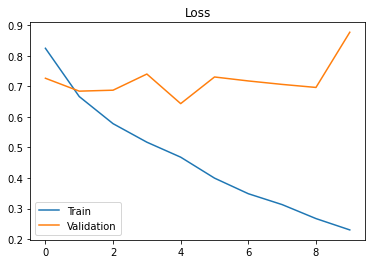

In [12]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'lower left')
plt.title("Loss")
plt.show()

- Display **accuracy** curves:

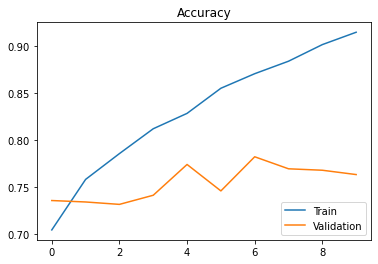

In [13]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [14]:

# Diretório dos dados de teste (substitua pelo caminho correto)
test_data_directory = "C:\\Users\\User\\Downloads\\data-split\\test"

# Defina os parâmetros do gerador de imagens para o conjunto de teste
test_data_generator = ImageDataGenerator()
test_generator = test_data_generator.flow_from_directory(
    directory=test_data_directory,
    classes=class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",  # Certifique-se de que o modo corresponda aos rótulos
    shuffle=False  # Não embaralhe os dados para que as previsões correspondam aos rótulos
)

# Faça previsões no conjunto de teste
predictions = model_cnn.predict(test_generator)

# Converta as previsões em rótulos de classe
predicted_labels = [class_names[i] for i in predictions.argmax(axis=1)]

# Obtenha os rótulos verdadeiros
true_labels = [class_names[i] for i in test_generator.classes]

# Crie um relatório de classificação
classification_report_result = classification_report(true_labels, predicted_labels, target_names=class_names)

# Imprima o relatório de classificação
print(classification_report_result)

Found 986 images belonging to 7 classes.
31/31 [==============================] - 37s 1s/step
                               precision    recall  f1-score   support

             Melanocytic_nevi       0.50      0.33      0.40        33
                     Melanoma       0.38      0.30      0.34        33
Benign_keratosis_like_lesions       0.56      0.65      0.60       111
         Basal_cell_carcinoma       0.38      0.42      0.40        12
            Actinic_keratoses       0.91      0.86      0.88       670
             Vascular_lesions       0.40      0.57      0.47       112
               Dermatofibroma       0.75      0.40      0.52        15

                     accuracy                           0.75       986
                    macro avg       0.56      0.50      0.52       986
                 weighted avg       0.77      0.75      0.76       986



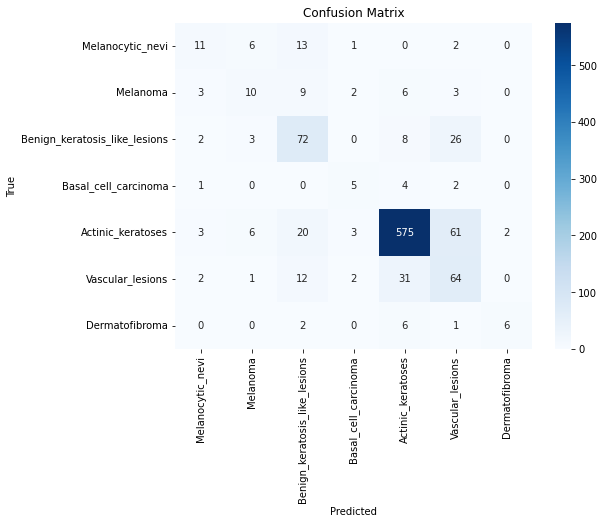

In [15]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plote a matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Step 5 - Concat Models



In [28]:
# Carregue a imagem usando o OpenCV
image_path = 'C:\\Users\\User\\Downloads\\data\\Basal_cell_carcinoma\\ISIC_0024331.jpg'  # Substitua pelo caminho da sua imagem
imagem = cv.imread(image_path)

# Verifique se a imagem foi carregada corretamente
# Extraia as dimensões da imagem
altura, largura, canais = imagem.shape

# Exiba as dimensões
print(f'Altura: {altura} pixels')
print(f'Largura: {largura} pixels')
print(f'Canais: {canais} canais (BGR)')


Altura: 450 pixels
Largura: 600 pixels
Canais: 3 canais (BGR)


In [47]:
# Assuming you have already defined and trained your tabular (model_ff) and image (model_cnn) models

# Create an input layer for the tabular data
input_tabular = layers.Input(shape=(X_train_scaled.shape[1],))

# Create an input layer for the image data
input_images = layers.Input(shape=(altura, largura, canais))

# Get the output of the tabular model
output_tabular = model_ff(input_tabular)

# Get the output of the image model
output_images = model_cnn(input_images)

# Concatenate the outputs of both models
concatenated = layers.concatenate([output_tabular, output_images])

# Define your data generators for images
# train_generator and test_generator should be set up to yield batches of image data and labels
# Ensure that the data types and shapes are compatible with the model's input layers

# Assuming y_train and y_test are NumPy arrays or properly prepared
y_train = np.array(y_train)
y_test = np.array(y_test)

# Create the final output layer
output = layers.Dense(7, activation='softmax')(concatenated)  # Adjust num_classes as needed

# Create the combined model
combined_model = Model(inputs=[input_tabular, input_images], outputs=output)

# Compile the combined model
combined_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',  # Use appropriate loss for your task
                       metrics=['accuracy'])

# Print model summary
combined_model.summary()

# Train the combined model
#combined_model.fit([X_train_scaled, train_generator], y_train, epochs=10, batch_size=32)

# Evaluate the combined model on the test data
#test_loss, test_acc = combined_model.evaluate([X_test_scaled, test_generator], y_test)
print(f'Test accuracy: {test_acc}')


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 3)]                  0         []                            
                                                                                                  
 input_26 (InputLayer)       [(None, 450, 600, 3)]        0         []                            
                                                                                                  
 sequential_5 (Sequential)   (None, 7)                    239495    ['input_25[0][0]']            
                                                                                                  
 model (Functional)          (None, 7)                    2480973   ['input_26[0][0]']            
                                                          5                                 

In [ ]:
# Train the combined model (uncomment the following line when you're ready to train the model)
# combined_model.fit([X_train_scaled, train_generator], y_train, epochs=10, batch_size=32)

# Evaluate the combined model on the test data
#test_loss, test_acc = combined_model.evaluate([X_test_scaled, test_generator], y_test)

# Get predictions on the test data
predictions = combined_model.predict([X_test_scaled, test_generator])

# Convert softmax probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded true labels to class labels
true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
classification_rep = classification_report(true_classes, predicted_classes)

# Print the classification report
print(classification_rep)

### Step 6 - Test the model on a new image

To test your model and predict which classes new images belong to, you can import sounds into a /workspace/data_test folder.

In [ ]:
predictions = combined_model.predict(X_test_scaled)

# 'predictions' will contain the predicted probabilities for each class
# You can use np.argmax(predictions, axis=1) to get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# 'predicted_labels' contains the predicted class labels for your input data
print(predicted_labels)

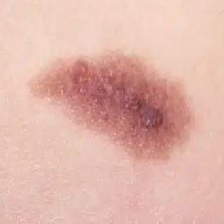

In [40]:
img = tf.keras.preprocessing.image.load_img('C:\\Users\\User\\Downloads\\b.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array])
img

In [41]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)

1/1 [==============================] - 1s 582ms/step
[[9.9167198e-01 7.7589829e-03 4.3803611e-04 9.4052757e-06 1.5032346e-06
  9.8188670e-05 2.1949070e-05]]


In [42]:
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

[0]


In [43]:
# transform classes number into classes name
class_names[class_id.item()]

'Melanocytic_nevi'